### Stellar Classification Project

By Jenica Andersen

This project aims to classify observations of stellar objects into three categories: Star, Galaxy, or Quasar (an active galactic nucleus). The dataset is available on [Kaggle.com](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) 

These are the steps this project will execute:

1. Obtain, import, visualize, and clean the data 
- Set object ID as string
- remove null row
- remove unnecessary columns
- remove QSO rows
- create binary class column
2. Split the data into 70% training data and 30% testing data using train-test-split. 
5. Determine the metrics used to evaluate each model performance. (roc_auc, precision, recall, f1, )
3. Establish pipeline (separate one for each model) that includes scaling the data and running KNN, Logistic Regression and Random Forest.
4. Perform RandomizedSearchCV initially, then GridSearchCV via the pipeline, preprocess, validate and tune the parameters
5. train the best model + parameters on all of the data. Test on the hold out data
6. Visialize results (confusion matrix heatmap, ROC AUC curve)
7. Run multiclass and other experiments of interest
8. Report results!


In [121]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, r2_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest

**1. Obtain, import, visualize, and clean the data**

In [2]:
#import dataset from https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17
data = pd.read_csv (r'star_classification.csv')

In [3]:
data.head()

obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1  GALAXY  0.779136  10445  58158       427  
2  GALAXY  0.644195   4576  55592       299  
3  GALAXY  0.932346   9149  58039       775  
4  GALAXY  0.116123   6121  56187       842

In [220]:
data.value_counts('class')

class
GALAXY    59445
STAR      21594
QSO       18961
dtype: int64

In [221]:
59445/100000

0.59445

In [4]:
#look at the data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

* obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
* alpha = Right Ascension angle (at J2000 epoch)
* delta = Declination angle (at J2000 epoch)
* u = Ultraviolet filter in the photometric system
* g = Green filter in the photometric system
* r = Red filter in the photometric system
* i = Near Infrared filter in the photometric system
* z = Infrared filter in the photometric system
* run_ID = Run Number used to identify the specific scan
* rereun_ID = Rerun Number to specify how the image was processed
* cam_col = Camera column to identify the scanline within the run
* field_ID = Field number to identify each field
* spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
* class = object class (galaxy, star or quasar object)
* redshift = redshift value based on the increase in wavelength
* plate = plate ID, identifies each plate in SDSS
* MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
* fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


In [5]:
#Change the obj ID to string
data = data.astype({"obj_ID":str}) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  object 
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(9), int64(7), 

In [129]:
X_bln_test

alpha      delta         u         g         r         i  \
75721   16.956890   3.646130  23.33542  21.95143  20.48149  19.60300   
80184  240.063240   6.134131  17.86033  16.79228  16.43001  16.30923   
19864   30.887222   1.188710  18.18911  16.89469  16.42161  16.24627   
76699  247.594401  10.887780  24.99961  21.71203  21.47148  21.30532   
92991   18.896451  -5.261330  23.76648  21.79737  20.69543  20.23403   
...           ...        ...       ...       ...       ...       ...   
42648   95.314424   1.320157  18.86225  17.18391  16.77306  16.63181   
86306  256.239646  36.085867  24.01340  22.37326  21.27724  20.19680   
45466  209.415904  49.847828  22.96547  21.31387  20.76264  20.54450   
63724  226.833308  26.109964  19.43374  19.30742  19.31334  19.08557   
34122   46.955845   0.855016  22.63321  20.80416  19.37463  18.11353   

              z  field_ID  plate  fiber_ID  redshift  
75721  19.13094       442   4312       495  0.506237  
80184  16.25873       243   2175       348  0.000345  
19864  16.18549       536   7332       943  0.000004  
76699  21.29109       134   4066       326 -0.000291  
92991  19.97464       148   7914       363 -0.000136  
...         ...       ...    ...       ...       ...  
42648  16.44982       129   1259       556  0.000184  
86306  19.34389        71  10722        73  0.742717  
45466  20.39165       109   7432       867 -0.000238  
63724  19.05866       134   2154       254  1.687418  
34122  17.47328       113   1066       378  0.000159  

[30000 rows x 11 columns]

/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_12943/3523036036.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['class_bool'] = (data1['class']== 'STAR').astype(int)
/Users/vesper/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vesper/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lea

ROC AUC score =  0.7716221522629567


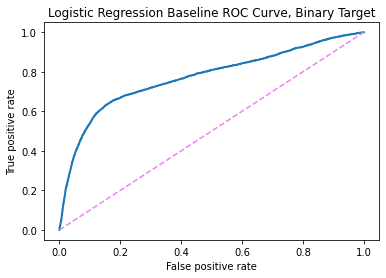

In [219]:
#baseline log reg model and plot. 
data1 = data[data['class'] != 'QSO']
data1['class_bool'] = (data1['class']== 'STAR').astype(int)

X_baseline = data1[['alpha','delta', 'u', 'g', 'r', 'i', 'z', 'field_ID', 'plate', 'fiber_ID', 'redshift']]
y_baseline = data1[['class_bool']]

X_bln_train, X_bln_test, y_bln_train, y_bln_test = train_test_split(X_baseline, y_baseline, test_size = .3, random_state = 42
                                                                   )
lr_baseline = LogisticRegression(C=1000)
lr_baseline.fit(X_bln_train, y_bln_train)

fpr, tpr, thresholds = roc_curve(y_bln_test, lr_baseline.predict_proba(X_bln_test)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression Baseline ROC Curve, Binary Target');
print("ROC AUC score = ", roc_auc_score(y_bln_test, lr_baseline.predict_proba(X_bln_test)[:,1]))
plt.savefig("roc_auc_log_regression_baseline_bool")

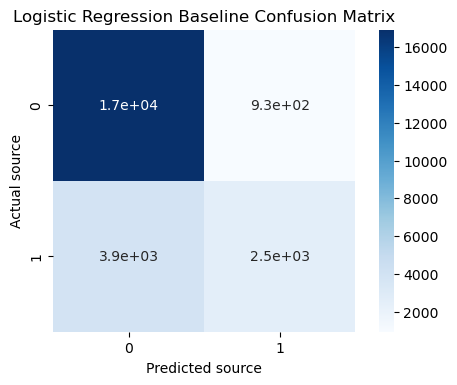

In [141]:
# Print confusion matrix for random forest final model
y_pred_bln = (lr_baseline.predict(X_bln_test))
lr_bln_confusion = confusion_matrix(y_bln_test, y_pred_bln)
plt.figure(dpi=100)
sns.heatmap(lr_bln_confusion, cmap = plt.cm.Blues, annot=True, square=True),
#           xticklabels=df3['class'],
#           yticklabels=df3['class'])

plt.xlabel('Predicted source')
plt.ylabel('Actual source')
plt.title('Logistic Regression Baseline Confusion Matrix');

plt.savefig("confusion_matrix_lr_baseline_bool")

In [6]:
df = data[data.u >0]
df.sort_values('u', ascending = True)

obj_ID       alpha      delta         u         g  \
57763   1.237665026524119e+18  208.358688  33.825699  10.99623  13.66217   
75784  1.2376623061996014e+18  239.473361  27.594369  12.10168  10.49820   
4472   1.2376623410859868e+18  239.423127  28.548438  12.26240  10.51139   
75620    1.23766230619947e+18  239.207155  27.898444  12.30349  10.67180   
75583  1.2376623061997322e+18  239.702668  27.467439  12.99664  11.33897   
...                       ...         ...        ...       ...       ...   
1046   1.2376794780072015e+18    0.115997  22.714164  29.19901  25.35543   
20225  1.2376637825953956e+18   19.689708  -1.058819  29.23438  25.40505   
19525  1.2376576295092892e+18  125.737753  33.875543  29.32565  20.29043   
21245      1.237663785281e+18   22.566355   0.950467  30.66039  30.60700   
56693    1.23766095810619e+18  120.265645  23.563929  32.78139  14.15644   

              r         i         z  run_ID  rerun_ID  cam_col  field_ID  \
57763  12.35763  12.63744  11.30247    4552       301        6       229   
75784  10.11604  10.00865  10.44131    3919       301        3       235   
4472   10.06854  13.41786  10.22551    3927       301        4        79   
75620  10.19460  10.05509  10.65056    3919       301        3       233   
75583  10.98255  10.87374  11.19448    3919       301        3       237   
...         ...       ...       ...     ...       ...      ...       ...   
1046   23.48086  21.56495  17.17135    7917       301        4       105   
20225  17.51251  16.55034  23.54460    4263       301        1       247   
19525  18.35283  17.85217  26.13011    2830       301        4       116   
21245  29.37411  30.25009  16.82299    4263       301        6       266   
56693  13.36123  26.30939  13.76284    3605       301        4        74   

        spec_obj_ID   class  redshift  plate    MJD  fiber_ID  
57763  2.383624e+18     QSO  3.955592   2117  54115       342  
75784  3.383405e+18    STAR  0.000008   3005  54876       274  
4472   3.383435e+18    STAR  0.000025   3005  54876       384  
75620  3.383416e+18    STAR  0.000003   3005  54876       316  
75583  3.383404e+18    STAR  0.000174   3005  54876       270  
...             ...     ...       ...    ...    ...       ...  
1046   8.630148e+18     QSO  0.253981   7665  57328       455  
20225  9.896750e+18    STAR -0.000167   8790  57363       328  
19525  5.001404e+18  GALAXY  0.503306   4442  55532       568  
21245  8.802546e+18    STAR -0.000456   7818  56989       947  
56693  1.423298e+18     QSO  1.658421   1264  52707       584  

[99999 rows x 18 columns]

In [7]:
#Select the columns of interest for our dataset and define X and y
df = df[['alpha','delta', 'u', 'g', 'r', 'i', 'z', 'field_ID', 'plate', 'fiber_ID', 'redshift', 'class']]

From my project proposal:
An individual sample/unit is an observed stellar object and its spectral characteristics. 
The columns of interest are: 
* alpha = Right Ascension angle (at J2000 epoch)
* delta = Declination angle (at J2000 epoch)
* u = Ultraviolet filter in the photometric system
* g = Green filter in the photometric system
* r = Red filter in the photometric system
* i = Near Infrared filter in the photometric system
* z = Infrared filter in the photometric system
* field_ID = Field number to identify each field
* redshift = redshift value based on the increase in wavelength
* plate = plate ID, identifies each plate in SDSS
* fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

The target will be **class** (object class--galaxy, star or quasar object)

In [8]:
df1 = df[df['class'] != 'QSO']
df1

alpha      delta         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99995   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99996   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99997  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99998  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99999  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z  field_ID  plate  fiber_ID  redshift   class  
0      18.79371        79   5812       171  0.634794  GALAXY  
1      21.61427       119  10445       427  0.779136  GALAXY  
2      18.94827       120   4576       299  0.644195  GALAXY  
3      19.25010       214   9149       775  0.932346  GALAXY  
4      15.54461       137   6121       842  0.116123  GALAXY  
...         ...       ...    ...       ...       ...     ...  
99995  20.73569       581   9374       438  0.000000  GALAXY  
99996  19.41526       289   7626       866  0.404895  GALAXY  
99997  17.35221       308   2764        74  0.143366  GALAXY  
99998  18.62482       131   6751       470  0.455040  GALAXY  
99999  19.28075        60   7410       851  0.542944  GALAXY  

[81038 rows x 12 columns]

In [13]:
df1['class_bool'] = (df1['class']== 'STAR').astype(int)
df1

/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_12943/245839788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['class_bool'] = (df1['class']== 'STAR').astype(int)


alpha      delta         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99995   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99996   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99997  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99998  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99999  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z  field_ID  plate  fiber_ID  redshift   class  class_bool  
0      18.79371        79   5812       171  0.634794  GALAXY           0  
1      21.61427       119  10445       427  0.779136  GALAXY           0  
2      18.94827       120   4576       299  0.644195  GALAXY           0  
3      19.25010       214   9149       775  0.932346  GALAXY           0  
4      15.54461       137   6121       842  0.116123  GALAXY           0  
...         ...       ...    ...       ...       ...     ...         ...  
99995  20.73569       581   9374       438  0.000000  GALAXY           0  
99996  19.41526       289   7626       866  0.404895  GALAXY           0  
99997  17.35221       308   2764        74  0.143366  GALAXY           0  
99998  18.62482       131   6751       470  0.455040  GALAXY           0  
99999  19.28075        60   7410       851  0.542944  GALAXY           0  

[81038 rows x 13 columns]

In [15]:
df2 = df1.loc[:,df1.columns!='class']
df2

alpha      delta         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99995   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99996   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99997  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99998  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99999  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z  field_ID  plate  fiber_ID  redshift  class_bool  
0      18.79371        79   5812       171  0.634794           0  
1      21.61427       119  10445       427  0.779136           0  
2      18.94827       120   4576       299  0.644195           0  
3      19.25010       214   9149       775  0.932346           0  
4      15.54461       137   6121       842  0.116123           0  
...         ...       ...    ...       ...       ...         ...  
99995  20.73569       581   9374       438  0.000000           0  
99996  19.41526       289   7626       866  0.404895           0  
99997  17.35221       308   2764        74  0.143366           0  
99998  18.62482       131   6751       470  0.455040           0  
99999  19.28075        60   7410       851  0.542944           0  

[81038 rows x 12 columns]

In [16]:
X = df2.loc[:, df2.columns!='class_bool']
y = df2['class_bool']

In [17]:
#Take a look
X

alpha      delta         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99995   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99996   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99997  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99998  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99999  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z  field_ID  plate  fiber_ID  redshift  
0      18.79371        79   5812       171  0.634794  
1      21.61427       119  10445       427  0.779136  
2      18.94827       120   4576       299  0.644195  
3      19.25010       214   9149       775  0.932346  
4      15.54461       137   6121       842  0.116123  
...         ...       ...    ...       ...       ...  
99995  20.73569       581   9374       438  0.000000  
99996  19.41526       289   7626       866  0.404895  
99997  17.35221       308   2764        74  0.143366  
99998  18.62482       131   6751       470  0.455040  
99999  19.28075        60   7410       851  0.542944  

[81038 rows x 11 columns]

In [18]:
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: class_bool, Length: 81038, dtype: int64

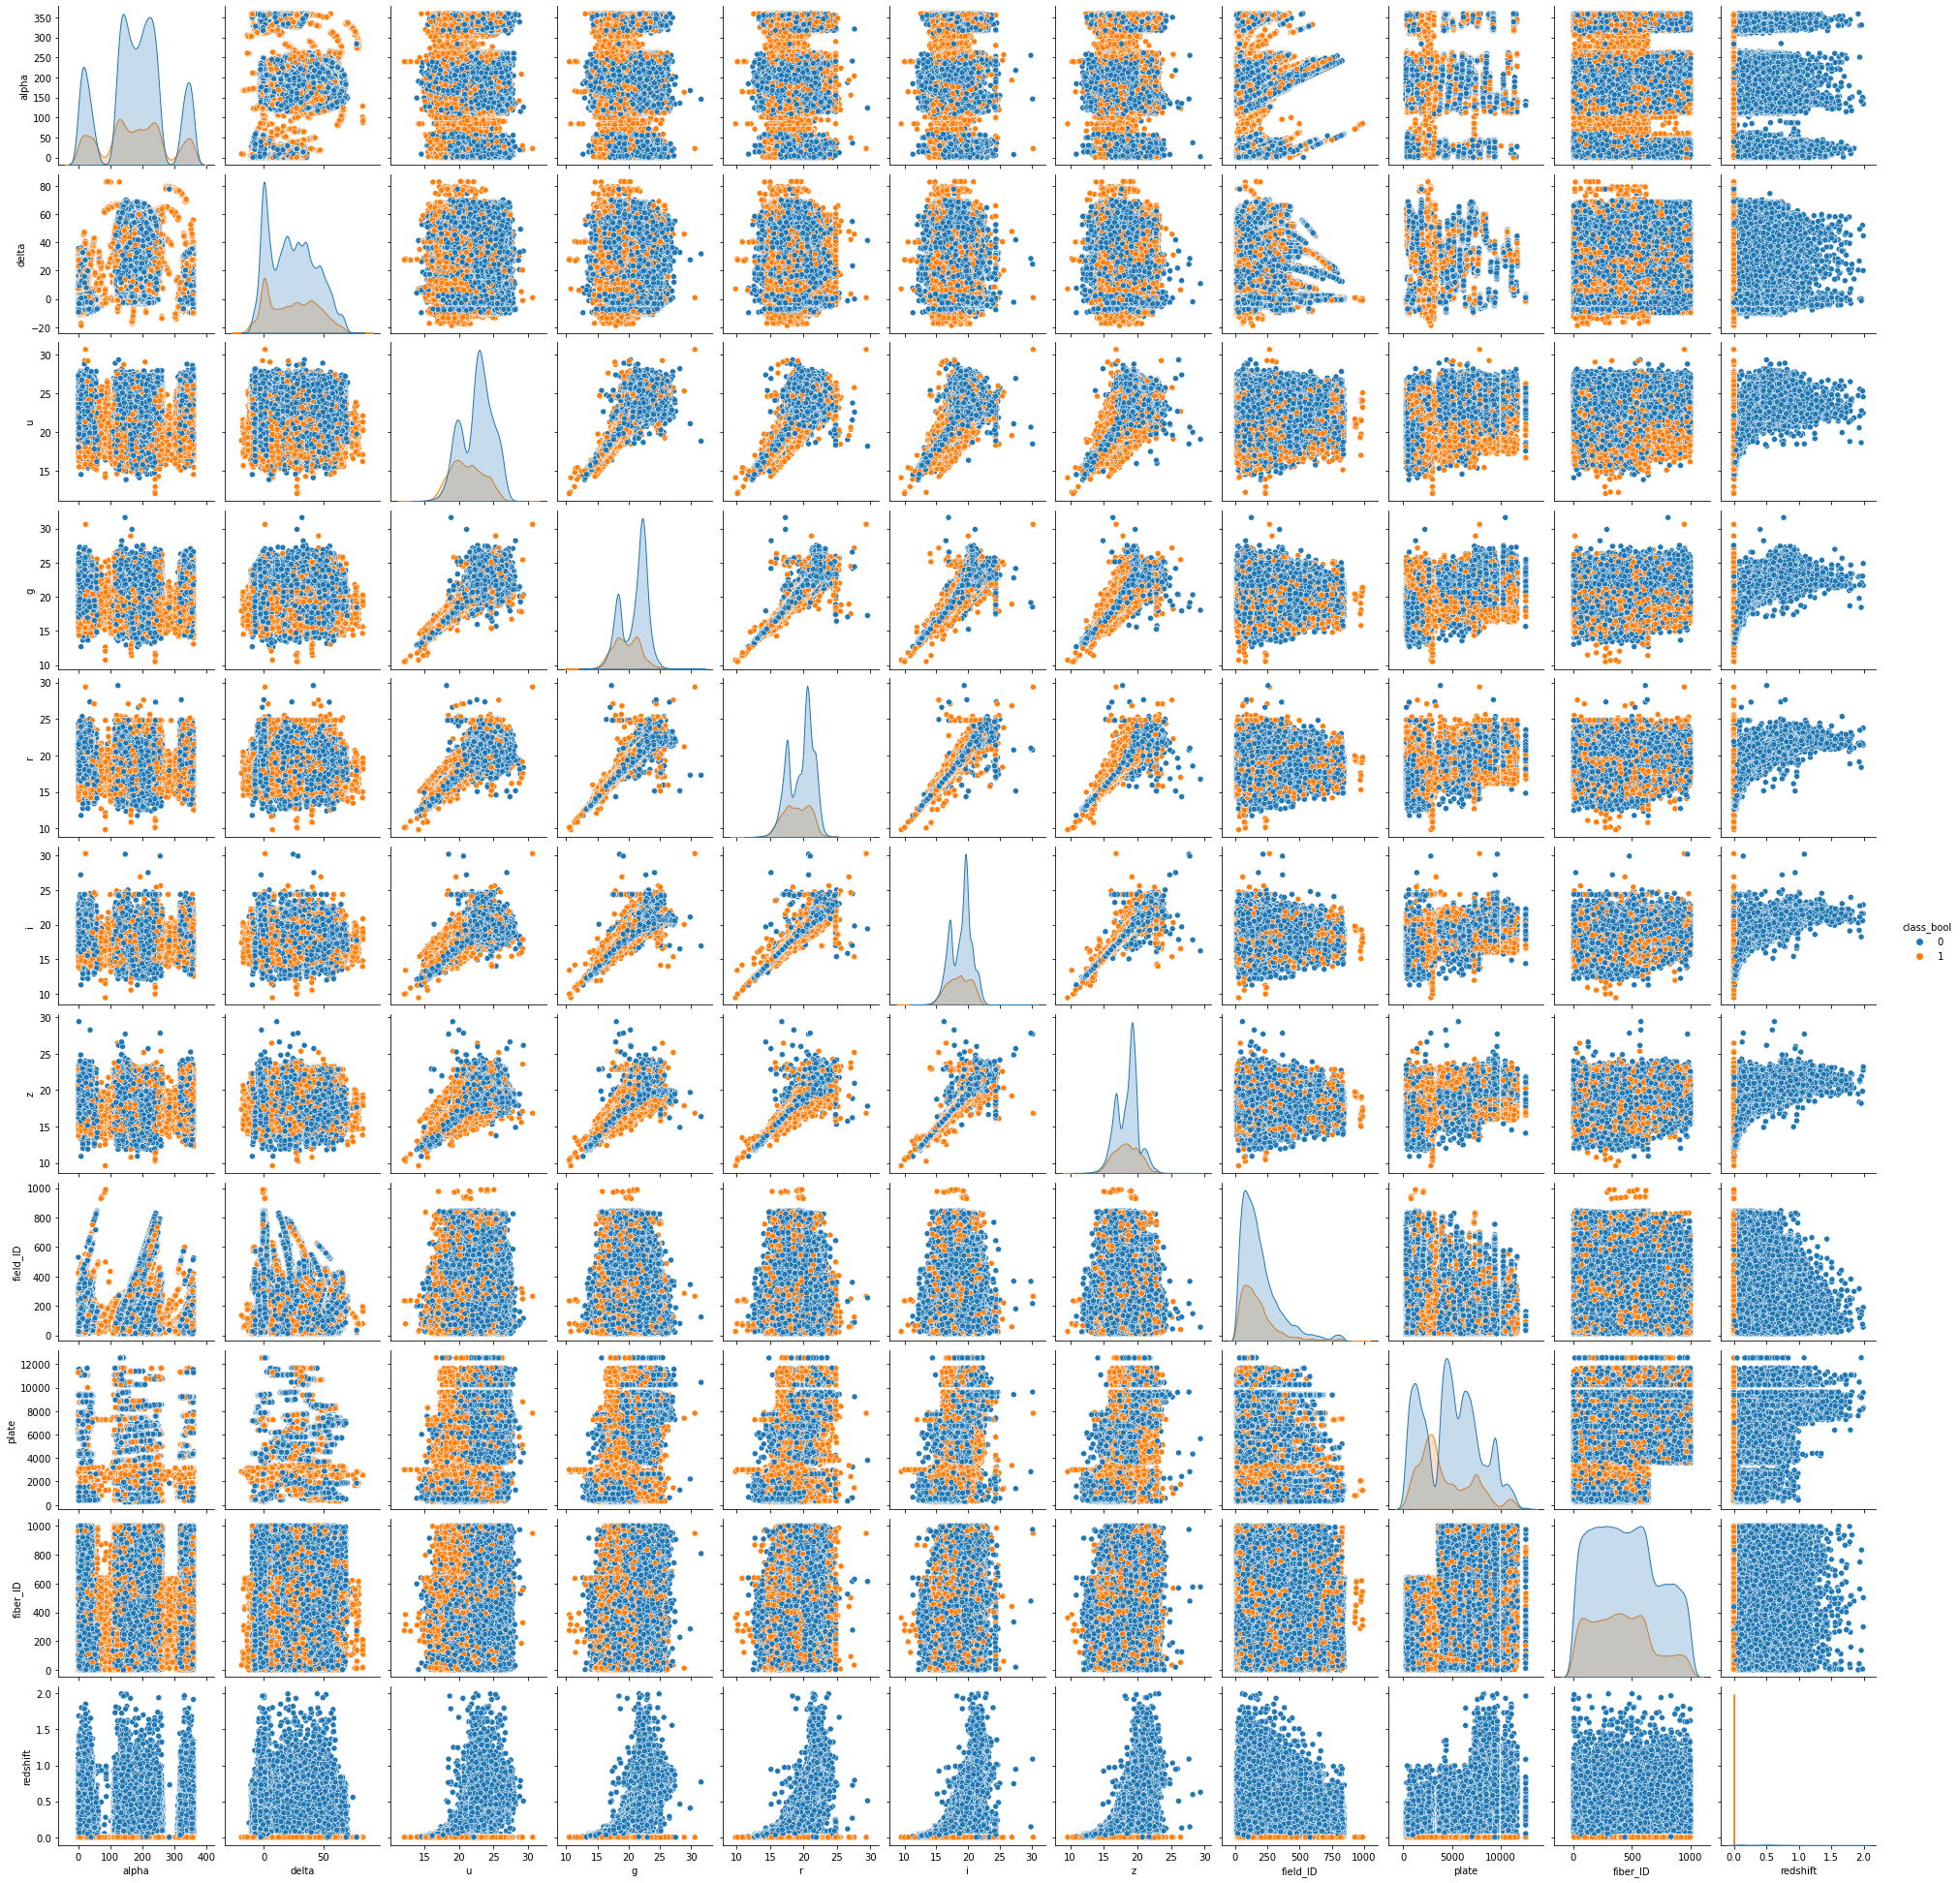

In [20]:
#plot up a quick pairplot (not so quick because of the size of the data) to see what correlations might exist
sns.pairplot(df2, hue="class_bool")

We see colinearity among the five columns with single letter names. Redshift may be a good variable to begin classification. 

Dimitri said that colinearity is not as much of a concern in logistic regression. random forest will handle dispersions from colinearity well. There is some dispersion and it is worth keeping all of the remotely colinear columns in. If its perfectly colinear, the extra data wont help the model, but here, the dispersion could be important. 

In [22]:
#Let's look at redshift a little closer
df2_redshift = df2[['redshift','class_bool']]
print("Star",df2_redshift.loc[df2_redshift['class_bool']== 1].describe())
print("Galaxy", df2_redshift.loc[df2_redshift['class_bool']== 0].describe())

#the star min is negative, and the max is larger than the min of the other two. 
#The range between -0.009971 to 2 is going to be the tricky stuff

#the galaxy min is negative too. The max is less than two. If redshift is > 2, its a quasar. 
#roughly: 0 and less is a star, 0-1 is a galaxy and 1 or higher is a quasar, is my guess.

Star            redshift  class_bool
count  21593.000000     21593.0
mean      -0.000115         1.0
std        0.000465         0.0
min       -0.004136         1.0
25%       -0.000295         1.0
50%       -0.000076         1.0
75%        0.000075         1.0
max        0.004153         1.0
Galaxy            redshift  class_bool
count  59445.000000     59445.0
mean       0.421596         0.0
std        0.264858         0.0
min       -0.009971         0.0
25%        0.164527         0.0
50%        0.456274         0.0
75%        0.594699         0.0
max        1.995524         0.0


In [23]:
X_train, X_ho, y_train, y_ho = train_test_split(X, y, test_size = 0.3, random_state=42)

In [27]:
X_train

alpha      delta         u         g         r         i  \
62532   33.300420  -0.557220  23.71767  22.90756  20.93120  19.67037   
73769  240.005822  53.621260  24.01447  21.12009  19.32880  18.52432   
76018  137.596001  32.815162  23.94187  21.89939  20.35353  19.57595   
88026  152.941966  -2.404891  24.30078  22.18216  20.81894  19.88161   
8862   148.550883  48.256847  19.58064  17.72079  16.67419  16.23040   
...           ...        ...       ...       ...       ...       ...   
7828   191.129820  36.304924  22.87463  22.11768  20.19325  19.29559   
67416  355.884797  15.582262  20.52110  18.26683  17.25319  16.86279   
94905  200.886792  37.524937  17.76181  16.50595  15.92192  15.56348   
1028     1.936603  16.067392  22.84614  20.89543  18.97654  18.23691   
19593  183.681361  -2.130265  24.23713  22.38218  21.11134  20.23968   

              z  field_ID  plate  fiber_ID  redshift  
62532  19.15290        88   4235        21  0.592008  
73769  18.02921       133   6709       111  0.471527  
76018  19.13461        47   5811       377  0.465456  
88026  19.59274        97   3769       141  0.643535  
8862   15.87680        47   1005       115  0.131020  
...         ...       ...    ...       ...       ...  
7828   18.89231       205   3973       431  0.493786  
67416  16.60096       276   3130       458 -0.000033  
94905  15.35302        31   2102       385  0.062848  
1028   17.80463       315    751       611  0.352488  
19593  19.95938       205   3777       439  0.528958  

[56726 rows x 11 columns]

In [34]:
#Some of this code is based off of Dimitri's office hours notebook
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNN())])

knn_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              # we named the second step knn, so we have to use that name here
              'knn__n_neighbors': range(1, 100),
             'knn__weights': ('uniform', 'distance')}

knn_grid = RandomizedSearchCV(knn_pipe, knn_param_grid, cv=5, n_jobs = -1, random_state = 42, scoring = 'roc_auc')
knn_grid.fit(X_train, y_train)

print(knn_grid.best_params_)
print('ROC AUC score:', knn_grid.score(X_ho, y_ho))

{'scaler': StandardScaler(), 'knn__weights': 'distance', 'knn__n_neighbors': 14}
ROC AUC score: 0.9900258061905708


randomized search cv: {'scaler': StandardScaler(), 'knn__weights': 'uniform', 'knn__n_neighbors': 9}
ROC AUC score: 0.9883226454706252

gridsearchcv {'knn__n_neighbors': 9, 'knn__weights': 'distance', 'scaler': StandardScaler()}
ROC AUC score: 0.9889796972302777

randomized search cv: {'scaler': StandardScaler(), 'knn__weights': 'distance', 'knn__n_neighbors': 14}
ROC AUC score: 0.9900258061905708

#### gridsearchcv {'knn__n_neighbors': 15, 'knn__weights': 'distance', 'scaler': StandardScaler()} ROC AUC score: 0.9900183751910774

In [38]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNN())])

knn_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              # we named the second step knn, so we have to use that name here
              'knn__n_neighbors': range(10,20),
             'knn__weights': ('uniform', 'distance')}

knn_grid = GridSearchCV(knn_pipe, knn_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
knn_grid.fit(X_train, y_train)

print(knn_grid.best_params_)
print('ROC AUC score:', knn_grid.score(X_ho, y_ho))

{'knn__n_neighbors': 15, 'knn__weights': 'distance', 'scaler': StandardScaler()}
ROC AUC score: 0.9900183751910774


In [48]:
logres_pipe = Pipeline([('scaler', StandardScaler()), ('logres', LogisticRegression(max_iter = 1000))])

logres_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'logres__C': np.arange(0.01, 100, 0.01),
             'logres__class_weight': ('balanced', 'none'),
                    #'logres__max_iter': range(100-100000)
                    }


logres_grid = RandomizedSearchCV(logres_pipe, logres_param_grid, cv=5, n_jobs = -1, random_state = 42, scoring = 'roc_auc')
logres_grid.fit(X_train, y_train)
print(logres_grid.best_params_)
print('ROC AUC score:', logres_grid.score(X_ho, y_ho))

{'scaler': StandardScaler(), 'logres__class_weight': 'none', 'logres__C': 40.06}
ROC AUC score: 0.9967954380276178


randomized search cv (c arange (0.01-10): {'scaler': StandardScaler(), 'logres__class_weight': 'none', 'logres__C': 9.01}
ROC AUC score: 0.996469300683343 

randomized search cv (c arange (0.01-100) {'scaler': StandardScaler(), 'logres__class_weight': 'balanced', 'logres__C': 82.01}
ROC AUC score: 0.9968382315352389

randomized search cv (c arange (0.01-100, 0.01) {'scaler': StandardScaler(), 'logres__class_weight': 'none', 'logres__C': 40.06}
ROC AUC score: 0.9967954380276178

In [50]:
logres_pipe = Pipeline([('scaler', StandardScaler()), ('logres', LogisticRegression(max_iter = 1000))])

logres_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'logres__C': np.arange(83, 85, 0.01),
             'logres__class_weight': ('balanced', 'none'),
                    }

logres_grid = GridSearchCV(logres_pipe, logres_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
logres_grid.fit(X_train, y_train)
print(logres_grid.best_params_)
print('ROC AUC score:', logres_grid.score(X_ho, y_ho))

{'logres__C': 84.98000000000101, 'logres__class_weight': 'none', 'scaler': StandardScaler()}
ROC AUC score: 0.9968587581485935


gridsearchCV with c= range(35,85) {'logres__C': 84, 'logres__class_weight': 'none', 'scaler': StandardScaler()} ROC AUC score: 0.9968577922926876

#### gridsearchCV with c= range(35,85, 0.01) {'logres__C': 84.98000000000101, 'logres__class_weight': 'none', 'scaler': StandardScaler()} ROC AUC score: 0.9968587581485935

In [59]:
#from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
#              'rf__max_depth': max_depth,
                }

rf_grid = RandomizedSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, random_state = 42, scoring = 'roc_auc')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)
print('ROC AUC score:', rf_grid.score(X_ho, y_ho))


{'scaler': StandardScaler(), 'rf__n_estimators': 700, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt'}
ROC AUC score: 0.9996180083398613


'\nmax_features, min_samples_leaf, n_estimators, and maybe max_depth\nset n_jobs=-1\nand for n estimators try out like 100 and 500\n'

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': (0,n_features),
              'rf__min_samples_leaf': range(10,1000),
              'rf__n_estimators': range(10,500),
                }

**{'scaler': StandardScaler(), 'rf__n_estimators': 55, 'rf__min_samples_leaf': 397, 'rf__max_features': 11}
ROC AUC score: 0.9994315459415669**

-------------------------------------------------------------------------
max_features = ['auto', 'sqrt']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
                }

rf_grid = RandomizedSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, random_state = 42, scoring = 'roc_auc')
rf_grid.fit(X_train, y_train)

**{'scaler': StandardScaler(), 'rf__n_estimators': 700, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt'}
ROC AUC score: 0.9996180083398613**
______________________________________________
max_features = ['auto', 'sqrt']
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 10)]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,

                }

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
rf_grid.fit(X_train, y_train)
**{'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__n_estimators': 944, 'scaler': MinMaxScaler()}
ROC AUC score: 0.9996541670265061**

In [63]:
#from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
#              'rf__max_depth': max_depth,
                }

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)
print('ROC AUC score:', rf_grid.score(X_ho, y_ho))


KeyboardInterrupt: 

In [65]:
X_train_photometric = X_train[['u', 'g', 'r', 'i', 'z']]
X_ho_photometric = X_ho[['u', 'g', 'r', 'i', 'z']]
#from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]#, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
#              'rf__max_depth': max_depth,
                }

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
rf_grid.fit(X_train_photometric, y_train)
print(rf_grid.best_params_)
print('ROC AUC score:', rf_grid.score(X_ho_photometric, y_ho))
#output
# {'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 1000, 'scaler': StandardScaler()}
# ROC AUC score: 0.9665974223394203

{'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 1000, 'scaler': StandardScaler()}
ROC AUC score: 0.9665974223394203


In [71]:
X_train

alpha      delta         u         g         r         i  \
62532   33.300420  -0.557220  23.71767  22.90756  20.93120  19.67037   
73769  240.005822  53.621260  24.01447  21.12009  19.32880  18.52432   
76018  137.596001  32.815162  23.94187  21.89939  20.35353  19.57595   
88026  152.941966  -2.404891  24.30078  22.18216  20.81894  19.88161   
8862   148.550883  48.256847  19.58064  17.72079  16.67419  16.23040   
...           ...        ...       ...       ...       ...       ...   
7828   191.129820  36.304924  22.87463  22.11768  20.19325  19.29559   
67416  355.884797  15.582262  20.52110  18.26683  17.25319  16.86279   
94905  200.886792  37.524937  17.76181  16.50595  15.92192  15.56348   
1028     1.936603  16.067392  22.84614  20.89543  18.97654  18.23691   
19593  183.681361  -2.130265  24.23713  22.38218  21.11134  20.23968   

              z  field_ID  plate  fiber_ID  redshift  
62532  19.15290        88   4235        21  0.592008  
73769  18.02921       133   6709       111  0.471527  
76018  19.13461        47   5811       377  0.465456  
88026  19.59274        97   3769       141  0.643535  
8862   15.87680        47   1005       115  0.131020  
...         ...       ...    ...       ...       ...  
7828   18.89231       205   3973       431  0.493786  
67416  16.60096       276   3130       458 -0.000033  
94905  15.35302        31   2102       385  0.062848  
1028   17.80463       315    751       611  0.352488  
19593  19.95938       205   3777       439  0.528958  

[56726 rows x 11 columns]

In [72]:
#Scale the data before modeling. Fit the scaler to the training data, then apply that scale to the test data too. 
#split the data into training and test data. One third of the data will be used as test data.
X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train, test_size = 0.3, random_state = 42)
scaler = StandardScaler().fit(X_train1)
X_train_scaled = scaler.transform(X_train1)
X_test_scaled = scaler.transform(X_val)
type(X_train_scaled)
#Do I need to turn X back into a df? I do.

numpy.ndarray

In [73]:
#some code on how to change array to df that from https://datatofish.com/numpy-array-to-pandas-dataframe/
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = ['alpha','delta', 'u','g','r','i','z','field_ID','plate','fiber_ID','redshift'])#, index = ['Item_1', 'Item_2'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = ['alpha','delta', 'u','g','r','i','z','field_ID','plate','fiber_ID','redshift'])

In [74]:
#Now begin to fit the model, starting with linear regression, using code from Metis lecture and measuring the score using log loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

for col in X_train_scaled_df.columns:
    print(col)
    X_tr = X_train_scaled_df[[col]]
    X_va = X_test_scaled_df[[col]]
    lr_model = LogisticRegression(C=84.98000000000101)
    lr_model.fit(X_tr,y_train1)
    y_prob_pred_test = lr_model.predict_proba(X_va)[:,1]
    print(log_loss(y_val,y_prob_pred_test))

alpha
0.5763630013073437
delta
0.5762262267990943
u
0.5400399832000615
g
0.5425730279723301
r
0.5654961887854988
i
0.57324069023966
z
0.5757901854691938
field_ID
0.5757931609773025
plate
0.5715024971264396
fiber_ID
0.5741450919073944
redshift
0.030180014897803926


- alpha 0.5763630013073437
- delta 0.5762262267990943
- u 0.5400399832000615
- g 0.5425730279723301
- r 0.5654961887854988
- i 0.57324069023966
- z 0.5757901854691938
- field_ID 0.5757931609773025
- plate 0.5715024971264396
- fiber_ID 0.5741450919073944
- redshift 0.030180014897803926

#### Now I will use my best model-- Random Forest, with: 
- max_features': 'sqrt'  
- min_samples_leaf': 4 
- n_estimators': 944, 
- 'scaler': MinMaxScaler() 

Which obtained ROC AUC score: 0.9996541670265061

Fit it on all the data, without to CV, and see how well the model performs. 

In [85]:
X_ho

alpha      delta         u         g         r         i  \
44651  157.447017   3.664682  21.58084  17.36473  16.49899  16.07631   
94475  224.966722  35.914852  22.73895  20.84994  20.07958  19.74549   
10777  250.047491  36.588712  17.35560  16.11243  16.28781  16.42525   
32161  115.543757  15.658972  24.12522  21.94674  20.14503  19.18771   
2750    37.956552  -1.184589  22.84938  22.62527  22.85454  21.41978   
...           ...        ...       ...       ...       ...       ...   
92051  217.755080  16.896617  21.83657  20.66047  19.71275  18.90875   
24233  110.681111  -0.254710  18.96003  17.18036  16.46474  16.17471   
24378  165.617085  59.280660  24.63466  23.75071  21.82231  21.73886   
54613  236.285477  46.008518  23.62308  21.27584  20.38951  19.96822   
29555  118.034536  39.575033  22.91309  21.02355  20.56480  20.32511   

              z  field_ID  plate  fiber_ID  redshift  
44651  15.80617       258    576       138  0.061655  
94475  19.60127       384   1384       445  0.000031  
10777  16.51315       263   2174       380 -0.000317  
32161  18.62003       133   4497       355  0.547286  
2750   20.99560       369   9313       715  0.735765  
...         ...       ...    ...       ...       ...  
92051  18.40742       170   5464       144  0.678684  
24233  16.00187        29   7450       149  0.000030  
24378  22.38972        87   8184       724 -0.000112  
54613  19.94551       170   6032       236 -0.000320  
29555  20.16153        85   3672        58 -0.000099  

[24312 rows x 11 columns]

In [104]:
#from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_final = RandomForestClassifier(max_features = 'sqrt', n_estimators = 944, min_samples_leaf = 4, n_jobs = -1, random_state = 42)
rf_final.fit(X_train, y_train)
y_pred = (rf_final.predict(X_ho))
print(f1_score(y_ho,y_pred))
#0.9475661548513558
#0.020030816640986136
#0.9955824226923972 my model fit on all the data and tested on the holdout data


print("roc:",roc_auc_score(y_ho,y_pred))
print("precision:",precision_score(y_ho,y_pred))
print("recall:",recall_score(y_ho,y_pred))
print("F1:", f1_score(y_ho,y_pred))
print(confusion_matrix(y_ho, y_pred))


0.9955824226923972
roc: 0.9983069285586406
precision: 0.9915097252238345
recall: 0.9996887159533074
F1: 0.9955824226923972
[[17832    55]
 [    2  6423]]


In [116]:
df3 = df1[df1['class']!="QSO"]
df3

alpha      delta         u         g         r         i  \
0      135.689107  32.494632  23.87882  22.27530  20.39501  19.16573   
1      144.826101  31.274185  24.77759  22.83188  22.58444  21.16812   
2      142.188790  35.582444  25.26307  22.66389  20.60976  19.34857   
3      338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454   
4      345.282593  21.183866  19.43718  17.58028  16.49747  15.97711   
...           ...        ...       ...       ...       ...       ...   
99995   39.620709  -2.594074  22.16759  22.97586  21.90404  21.30548   
99996   29.493819  19.798874  22.69118  22.38628  20.45003  19.75759   
99997  224.587407  15.700707  21.16916  19.26997  18.20428  17.69034   
99998  212.268621  46.660365  25.35039  21.63757  19.91386  19.07254   
99999  196.896053  49.464643  22.62171  21.79745  20.60115  20.00959   

              z  field_ID  plate  fiber_ID  redshift   class  class_bool  
0      18.79371        79   5812       171  0.634794  GALAXY           0  
1      21.61427       119  10445       427  0.779136  GALAXY           0  
2      18.94827       120   4576       299  0.644195  GALAXY           0  
3      19.25010       214   9149       775  0.932346  GALAXY           0  
4      15.54461       137   6121       842  0.116123  GALAXY           0  
...         ...       ...    ...       ...       ...     ...         ...  
99995  20.73569       581   9374       438  0.000000  GALAXY           0  
99996  19.41526       289   7626       866  0.404895  GALAXY           0  
99997  17.35221       308   2764        74  0.143366  GALAXY           0  
99998  18.62482       131   6751       470  0.455040  GALAXY           0  
99999  19.28075        60   7410       851  0.542944  GALAXY           0  

[81038 rows x 13 columns]

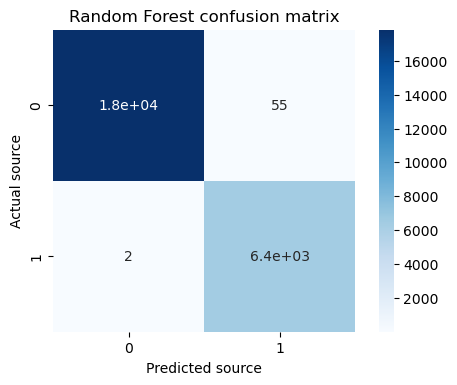

In [119]:
# Print confusion matrix for random forest final model
rf_final_confusion = confusion_matrix(y_ho, y_pred)
plt.figure(dpi=100)
sns.heatmap(rf_final_confusion, cmap=plt.cm.Blues, annot=True, square=True),
#           xticklabels=df3['class'],
#           yticklabels=df3['class'])

plt.xlabel('Predicted source')
plt.ylabel('Actual source')
plt.title('Random Forest confusion matrix');

plt.savefig("confusion_matrix_rf_final_bool")

### 0.9955824226923972

In [133]:
fpr, tpr, thresholds = roc_curve(y_ho, rf_final.predict_proba(X_ho)[:,1])

ROC AUC score =  0.9996425637035266


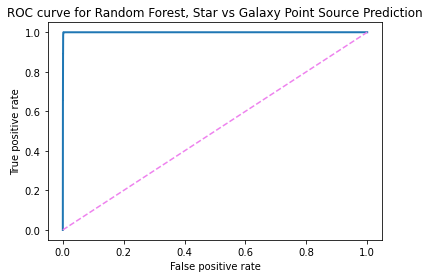

In [134]:
fpr, tpr, thresholds = roc_curve(y_ho, rf_final.predict_proba(X_ho)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Random Forest, Star vs Galaxy Point Source Prediction');
print("ROC AUC score = ", roc_auc_score(y_ho, rf_final.predict_proba(X_ho)[:,1]))
plt.savefig("roc_auc_rf_final_bool")

#### now try multiclass

In [152]:
y_mult.tail()

99996                                                   GALAXY
99997                                                   GALAXY
99998                                                   GALAXY
99999                                                   GALAXY
class_num    [0, 0, 0, 0, 0, 1, 1, 0, 0, -1, 0, 0, -1, 0, 0...
Name: class, dtype: object

In [165]:
#https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['class'] == 'STAR'),
    (df['class'] == 'GALAXY'),
    (df['class'] == 'QSO'),
    ]

# create a list of the values we want to assign for each condition
values = [-1, 0, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
y_mult['class_num'] = np.select(conditions, values)

# display updated DataFrame
y_mult.tail()

#y_mult['class_num'] = df['class'].apply(lambda series: label_source(series))#, axis=1)
       

99996                                                   GALAXY
99997                                                   GALAXY
99998                                                   GALAXY
99999                                                   GALAXY
class_num    [0, 0, 0, 0, 0, 1, 1, 0, 0, -1, 0, 0, -1, 0, 0...
Name: class, dtype: object

In [175]:
y_mult.to_frame()# ['class_num'] = df['class'].apply(lambda series: label_source(series))#, axis=1)
y_mult['test'] = df['class']
y_mult
y_mult_df = pd.DataFrame
#y_mult_df['test'] = df['redshift']
type(y_mult_df)

type

### The following cell is the multi class model using the rf_fin for the binary trials

In [201]:
X_mult_a = df.loc[:, df.columns!='class']
X_mult = X_mult_a.loc[:, X_mult_a.columns!='class_int']
y_mult = df['class_int']


X_mult_train, X_mult_test, y_mult_train, y_mult_test = train_test_split(X_mult, y_mult, test_size = 0.3, random_state = 42)
y_mult_test.to_numpy()

rf_final = RandomForestClassifier(max_features = 'sqrt', n_estimators = 400, min_samples_leaf = 4, n_jobs = -1, random_state = 42)
rf_final.fit(X_mult_train, y_mult_train)
y_mult_pred = (rf_final.predict(X_mult_test))
print(f1_score(y_mult_test,y_mult_pred, average='macro'))

#print("roc:",roc_auc_score(y_mult_test,y_mult_pred, multi_class='ovr'))
print("precision:",precision_score(y_mult_test,y_mult_pred, average='macro'))
print("recall:",recall_score(y_mult_test,y_mult_pred, average='macro'))
print("F1:", f1_score(y_mult_test,y_mult_pred, average='macro'))
print(confusion_matrix(y_mult_test,y_mult_pred))


0.9742071368816392
precision: 0.9779386406860971
recall: 0.9707674075518405
F1: 0.9742071368816392
[[ 5320   422     0]
 [  191 17574    51]
 [    0     4  6438]]


In [222]:
df.value_counts('class')

class
GALAXY    59445
STAR      21593
QSO       18961
dtype: int64

* precision: 0.9779386406860971
* recall: 0.9707674075518405
### * F1: 0.9742071368816392
* [[ 5320   422     0]
* [  191 17574    51]
* [    0     4  6438]]

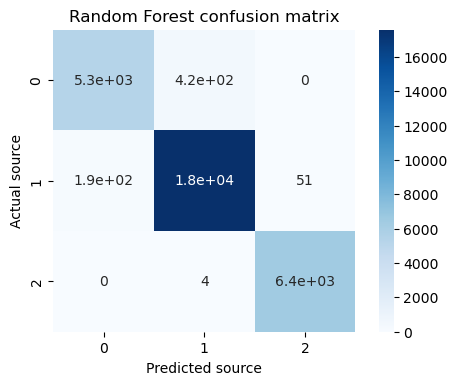

In [204]:
# Print confusion matrix for random forest final model
rf_final_multi_confusion = confusion_matrix(y_mult_test,y_mult_pred)
plt.figure(dpi=100)
sns.heatmap(rf_final_multi_confusion, cmap=plt.cm.Blues, annot=True, square=True),
#           xticklabels=df3['class'],
#           yticklabels=df3['class'])

plt.xlabel('Predicted source')
plt.ylabel('Actual source')
plt.title('Random Forest confusion matrix');

plt.savefig("confusion_matrix_rf_final_multi")

### Now try just redshift

In [207]:
X_red = df.loc[:, df.columns =='redshift']
y_red = df['class_int']


X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size = 0.3, random_state = 42)
y_red_test.to_numpy()

rf_final = RandomForestClassifier(max_features = 'sqrt', n_estimators = 400, min_samples_leaf = 4, n_jobs = -1, random_state = 42)
rf_final.fit(X_red_train, y_red_train)
y_red_pred = (rf_final.predict(X_red_test))
#print(f1_score(y_red_test,y_red_pred, average='macro'))

#print("roc:",roc_auc_score(y_mult_test,y_mult_pred, multi_class='ovr'))
print("precision:",precision_score(y_red_test,y_red_pred, average='macro'))
print("recall:",recall_score(y_red_test,y_red_pred, average='macro'))
print("F1:", f1_score(y_red_test,y_red_pred, average='macro'))
print(confusion_matrix(y_red_test,y_red_pred,))

#top row 5742    star
#mid row 17816   galaxy
#bottom row 6442  quasar

# no qso misclassified as stars and vice versa. 
# 1210 stars misclassified as galaxies
#397 galaxies misclassified as stars and 25 galaxies misclassified as qso
#7 qso misclassified as galaxies

precision: 0.9500649583170452
recall: 0.9214996125742502
F1: 0.9339768652801662
[[ 4532  1210     0]
 [  397 17394    25]
 [    0     7  6435]]


In [218]:
y_red_test.to_frame().value_counts()

class_int
 0           17816
 1            6442
-1            5742
dtype: int64

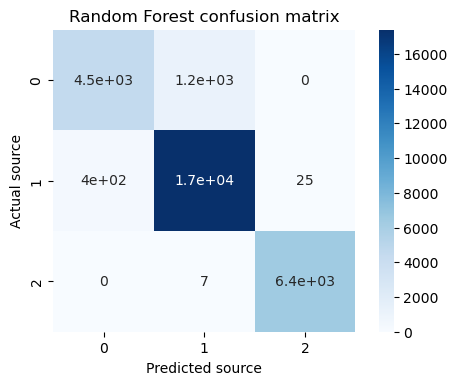

In [208]:
# Print confusion matrix for random forest final model
rf_final_red_confusion = confusion_matrix(y_red_test,y_red_pred)
plt.figure(dpi=100)
sns.heatmap(rf_final_red_confusion, cmap=plt.cm.Blues, annot=True, square=True),
#           xticklabels=df3['class'],
#           yticklabels=df3['class'])

plt.xlabel('Predicted source')
plt.ylabel('Actual source')
plt.title('Random Forest confusion matrix');

plt.savefig("confusion_matrix_rf_final_red")

pandas.core.series.Series

In [160]:
#from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
#              'rf__max_depth': max_depth,
                }

rf_grid = RandomizedSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, random_state = 42, scoring = 'roc_auc')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)
print('ROC AUC score:', rf_grid.score(X_ho, y_ho))


{'scaler': MinMaxScaler(), 'rf__n_estimators': 400, 'rf__min_samples_leaf': 2, 'rf__max_features': 'auto'}
ROC AUC score: 0.9996360245980007


### {'scaler': MinMaxScaler(), 'rf__n_estimators': 400, 'rf__min_samples_leaf': 2, 'rf__max_features': 'auto'}
### ROC AUC score: 0.9996360245980007

In [162]:
#from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

rf_param_grid = {'scaler': [MinMaxScaler(), StandardScaler()],
              'rf__max_features': max_features,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__n_estimators': n_estimators,
#              'rf__max_depth': max_depth,
                }

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs = -1, scoring = 'roc_auc')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)
print('ROC AUC score:', rf_grid.score(X_ho, y_ho))


{'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 766, 'scaler': StandardScaler()}
ROC AUC score: 0.9996585046766786


### {'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 766, 'scaler': StandardScaler()}
### ROC AUC score: 0.9996585046766786

#### the n_estimators range dramatically. what can I say about that?

--------------------------------------------------

In [178]:
# create a list of our conditions
conditions = [
    (df['class'] == 'STAR'),
    (df['class'] == 'GALAXY'),
    (df['class'] == 'QSO'),
     ]

# create a list of the values we want to assign for each condition
values = [1, 0, -1]

# create a new column and use np.select to assign values to it using our lists as arguments
df['class_int'] = np.select(conditions, values)

# display updated DataFrame
df.describe()

alpha         delta             u             g             r  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean     177.628653     24.135552     22.080679     20.631583     19.645777   
std       96.502612     19.644608      2.251068      2.037384      1.854763   
min        0.005528    -18.785328     10.996230     10.498200      9.822070   
25%      127.517698      5.147477     20.352410     18.965240     18.135795   
50%      180.900527     23.646462     22.179140     21.099930     20.125310   
75%      233.895005     39.901582     23.687480     22.123775     21.044790   
max      359.999810     83.000519     32.781390     31.602240     29.571860   

                  i             z      field_ID         plate      fiber_ID  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean      19.084865     18.768988    186.127011   5137.027890    449.315613   
std        1.757900      1.765982    149.007687   2952.312485    272.498252   
min        9.469903      9.612333     11.000000    266.000000      1.000000   
25%       17.732280     17.460830     82.000000   2526.000000    221.000000   
50%       19.405150     19.004600    146.000000   4987.000000    433.000000   
75%       20.396510     19.921120    241.000000   7400.500000    645.000000   
max       32.141470     29.383740    989.000000  12547.000000   1000.000000   

           redshift     class_int  
count  99999.000000  99999.000000  
mean       0.576667      0.026320  
std        0.730709      0.636282  
min       -0.009971     -1.000000  
25%        0.054522      0.000000  
50%        0.424176      0.000000  
75%        0.704172      0.000000  
max        7.011245      1.000000

In [22]:
df.class_int.value_counts()

 0    59445
-1    21593
 1    18961
Name: class_int, dtype: int64

In [23]:
#redefine X and y for the numeric class column
X = df.loc[:, df.columns!=('class', 'class_int')]
y = df['class_int']

In [117]:
lr_model_all = LogisticRegression(C=1000)
lr_model_all.fit(X_train_scaled_df, yb_train1)
y_prob_pred_test = lr_model_all.predict_proba(X_test_scaled_df)[:,1]
y_pred_test = lr_model_all.predict(X_val)#[:,1]
print(log_loss(yb_val,y_prob_pred_test))
print(accuracy_score(yb_val,y_pred_test))

0.022592372627748162
0.7852380952380953


I'm trying to run a quick model to see which variable might do better ('u' vs 'z'--maybe try the others too).

With u, the log loss was 0.0227 and accuracy score was 0.78. With z the log loss was 0.0225 and accuracy was 0.78524